In [2]:
%pip install --upgrade torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade pytorch_lightning

  Using cached pytorch_lightning-2.2.5-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 5.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pytorch_lightning
    Found existing installation: pytorch-lightning 1.4.9
    Uninstalling pytorch-lightning-1.4.9:
      Successfully uninstalled pytorch-lightning-1.4.9
Note: you may need to restart the kernel to use updated packages.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params
---------------------------------------------------------
0 | enc_embedding | DataEmbedding_inverted | 1.1 K 
1 | encoder       | ModuleList             | 66.9 K
2 | projector     | Linear                 | 520   
---------------------------------------------------------
68.6 K    Trainable params
0         Non-trainable params
68.6 K    Total params
0.274     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


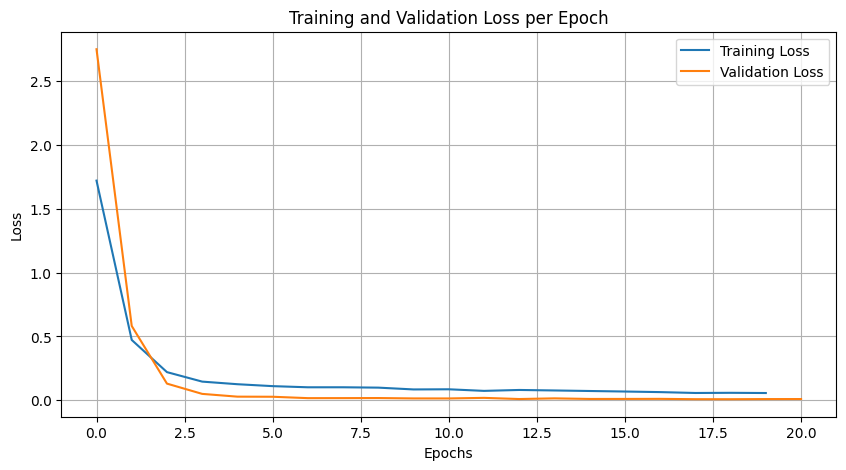

In [31]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

# Define TriangularCausalMask
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

# Define FullAttention
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

# Define DataEmbedding_inverted
class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, hidden_size, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, hidden_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        return self.dropout(x)

# Define the iTransformer model
class iTransformer(pl.LightningModule):
    def __init__(self, h, input_size, n_series, hidden_size=512, n_heads=8, e_layers=2, d_ff=2048, factor=1, dropout=0.1, use_norm=True, lr=1e-3):
        super(iTransformer, self).__init__()
        self.h = h
        self.input_size = input_size
        self.n_series = n_series
        self.hidden_size = hidden_size
        self.n_heads = n_heads
        self.e_layers = e_layers
        self.d_ff = d_ff
        self.factor = factor
        self.dropout = dropout
        self.use_norm = use_norm
        self.lr = lr

        self.enc_embedding = DataEmbedding_inverted(input_size, self.hidden_size, self.dropout)

        self.encoder = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=self.hidden_size, nhead=self.n_heads, dim_feedforward=self.d_ff, dropout=self.dropout)
            for _ in range(self.e_layers)
        ])

        self.projector = nn.Linear(self.hidden_size, h, bias=True)

    def forecast(self, x_enc):
        if self.use_norm:
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        enc_out = self.enc_embedding(x_enc, None)
        for layer in self.encoder:
            enc_out = layer(enc_out)

        dec_out = self.projector(enc_out).permute(0, 2, 1)[:, :, :self.n_series]

        if self.use_norm:
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))

        return dec_out

    def forward(self, windows_batch):
        insample_y = windows_batch['insample_y'].unsqueeze(-1)  # Add an extra dimension
        y_pred = self.forecast(insample_y)
        y_pred = y_pred[:, -self.h:, :]
        return y_pred

    def training_step(self, batch, batch_idx):
        output = self(batch)
        target = batch['insample_y'][:, -self.h:]
        loss = F.mse_loss(output.squeeze(), target)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self(batch)
        target = batch['insample_y'][:, -self.h:]
        val_loss = F.mse_loss(output.squeeze(), target)
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)

        mae = F.l1_loss(output.squeeze(), target)
        self.log('val_mae', mae, on_epoch=True, prog_bar=True)

        return {"val_loss": val_loss, "val_mae": mae}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Load the data
file_path = '/Users/lennartzahn/Desktop/Masterarbeit/Notebooks (Transformer)/Cleaned_Data_EMA.csv'
df = pd.read_csv(file_path)
df['ds'] = pd.to_datetime(df['ds'])

# Filter for a single unique_id (replace 'unique_id_value' with the actual unique_id you want to filter)
unique_id_value = 'User #25290'
df_single_id = df[df['unique_id'] == unique_id_value]

# Split data into train and validation sets
train_size = int(len(df_single_id) * 0.8)
df_train = df_single_id.iloc[:train_size]
df_val = df_single_id.iloc[train_size:]

# Define the dataset and dataloader
class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_size, h):
        self.df = df
        self.input_size = input_size
        self.h = h

    def __len__(self):
        return len(self.df) - self.input_size - self.h + 1

    def __getitem__(self, idx):
        insample_y = self.df['y'][idx:idx+self.input_size].values.astype(np.float32)
        return {"insample_y": torch.tensor(insample_y)}

# Set parameters and create dataloader
input_size = 16
h = 8
batch_size = 16

train_dataset = TimeSeriesDataset(df_train, input_size, h)
val_dataset = TimeSeriesDataset(df_val, input_size, h)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model with hyperparameters
model = iTransformer(
    h=h,
    input_size=input_size,
    n_series=1,
    hidden_size=64,
    n_heads=4,
    e_layers=2,
    d_ff=128,
    dropout=0.1,
    lr=1e-3,
)

# Define a PyTorch Lightning Callback for monitoring training
class PrintCallback(pl.callbacks.Callback):
    def on_epoch_end(self, trainer, pl_module):
        print(f'Epoch {trainer.current_epoch} - Train Loss: {trainer.callback_metrics["train_loss"]:.4f}')

# Create a callback to log the loss
class LossLogger(pl.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())



loss_logger = LossLogger()
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[PrintCallback(), loss_logger],
    default_root_dir='/Users/lennartzahn/Desktop/Masterarbeit/Notebooks (Transformer)',
    log_every_n_steps=5
)

trainer.fit(model, train_dataloader, val_dataloader)

# Define the prediction function
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            output = model(batch)
            predictions.append(output.numpy())
    return np.concatenate(predictions)

# Example prediction
predictions = predict(model, val_dataloader)


# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(loss_logger.train_losses, label='Training Loss')
plt.plot(loss_logger.val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
print("Train Losses:", loss_logger.train_losses)
print("Validation Losses:", loss_logger.val_losses)

Train Losses: [1.7193902730941772, 0.47249388694763184, 0.2206989824771881, 0.1464688777923584, 0.12611575424671173, 0.11105763167142868, 0.10206479579210281, 0.10214683413505554, 0.09934438019990921, 0.08524356782436371, 0.08645635843276978, 0.07396537065505981, 0.08113039284944534, 0.07722904533147812, 0.07303614169359207, 0.06886078417301178, 0.06434086710214615, 0.05751005932688713, 0.05881604179739952, 0.05716365948319435]
Validation Losses: [2.747581958770752, 0.5818902254104614, 0.1308000683784485, 0.0504339262843132, 0.028758851811289787, 0.027965279296040535, 0.01710205152630806, 0.017293306067585945, 0.01786614954471588, 0.014862759038805962, 0.01470796950161457, 0.019258566200733185, 0.010215289890766144, 0.015392158180475235, 0.010822538286447525, 0.010973424650728703, 0.011504477821290493, 0.0089046536013484, 0.008669923059642315, 0.009762896224856377, 0.010041393339633942]


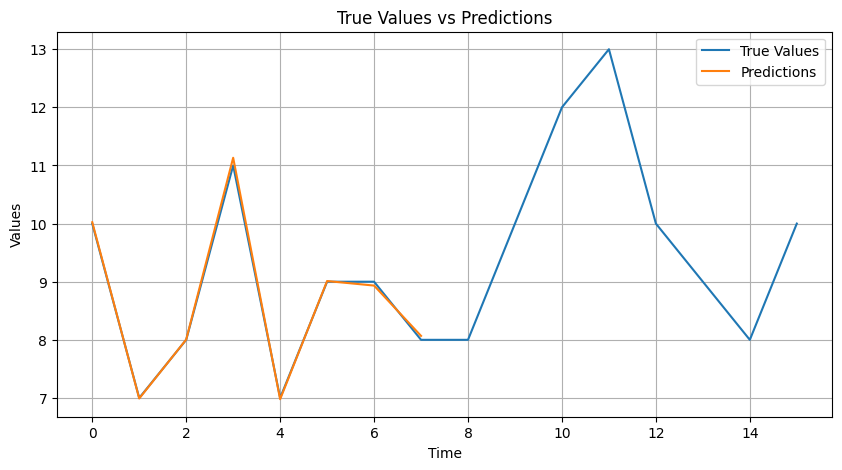

Mean Absolute Error: 2.099257707595825


In [81]:
# plot the prediction for the next 8 steps with true and predicted values
plt.figure(figsize=(10, 5))
plt.plot(df_val['y'].values[-16:], label='True Values')
plt.plot(predictions.squeeze()[-8:], label='Predictions')
plt.title('True Values vs Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the mean absolute error
mae = np.mean(np.abs(df_val['y'].values[-8:] - predictions.squeeze()[-8:]))
print("Mean Absolute Error:", mae)



In [61]:
# Save the model   
torch.save(model.state_dict(), '/Users/lennartzahn/Desktop/Masterarbeit/Notebooks (Transformer)/model.pth')